In [1]:
import sys
from check_calibration.ProbabilityIntegralTransfer import prob_integ_xfer
import numpy as np
from pprint import pprint
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle as pk

import os, sys
import check_calibration.utils as utils
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report

# from sensor_util import toMag_wrist, toMag_ring, csv_to_data, downsample, align_time, csv_to_final


%load_ext autoreload
%autoreload 2

In [9]:

# activities = ['climb down stairs', 'climb up stairs', 'jumping', 'lying', 'running', 'sitting', 'standing' , 'walking' ]
# activities = [
#     'lying',
#     'sitting',
#     'standing',
#     'walking',
#     'running',
#     'cycling',
#     'Nordic walking',
#     'Ascending stairs',
#     'Descending stairs',
#     'vacuum cleaning',
#     'Ironing',
#     'rope jumping'
# ]
activities = ['walking forward', 'walking counter-clockwise', 'walking clockwise', 'climbing up stairs', 
              'climbing down stairs', 'running', 'jumping', 'sitting', 'standing', 'lying', 'riding up elevator',
             'riding down elevator']
act_to_idx = {activities[i]: i for i in range(len(activities))}


# locations = ['all_loc', 'wrist']
locations = ['all_loc']

data_dir = 'data/usc-had_50'
ik_mode = '_ik'
noise_mode = ''

for loc in locations:

    Xy_real = pk.load(open(f"{data_dir}/real_{loc}.p",'rb'))
    X_real = Xy_real[0]
    y_real = Xy_real[1]
    for i in range(len(X_real)):
        X_real[i] = np.array(X_real[i])
        y_real[i] = np.array(y_real[i])
    # X_real = [X_real[i] for i in sub_array]
    # y_real = [y_real[i] for i in sub_array]   

    X_real_train = None
    y_real_train = None
    for j in range(len(X_real)):
        for cls_idx in np.unique(y_real[0]):
            # get index of cls in a subject
            cls_idx_all = np.where(y_real[j] == cls_idx)[0]
            X_real_cls = X_real[j][cls_idx_all]
            y_real_cls = y_real[j][cls_idx_all]

            if X_real_train is None:
                X_real_train = X_real_cls
                y_real_train = y_real_cls
            else:
                X_real_train = np.vstack((X_real_train, X_real_cls))
                y_real_train = np.concatenate((y_real_train, y_real_cls))
    X_real = X_real_train
    y_real = y_real_train

    print(X_real.shape)
    print(y_real.shape)
    print(np.unique(y_real))

    Xy_vir_raw = np.load(f'{data_dir}/resized_{loc}_raw{ik_mode}{noise_mode}.npz')
    X_vir_raw = Xy_vir_raw['x']
    y_vir_raw = Xy_vir_raw['y']

    print(np.unique(y_vir_raw))

    # print(np.where(np.abs(X_vir_raw)>50000))
    print(np.percentile(X_vir_raw, 90))
    # X_vir_raw[np.where(np.abs(X_vir_raw)>50000)] = 0
    # print(np.max(np.abs(X_vir_raw)))
    # y_vir_raw = np.ones(X_vir_raw.shape)*0
    # print(X_vir_raw.shape)

    print(np.all(np.isfinite(X_vir_raw)))

    perClass = True

    X_vir_cal = prob_integ_xfer(X_vir_raw, X_real,
                        y_vir=y_vir_raw, y_real=y_real, 
                        perClass=perClass, dict_class_sel=act_to_idx)
    y_vir_cal = y_vir_raw
    print (X_vir_cal.shape)
    np.savez(f'{data_dir}/resized_{loc}_cal{ik_mode}{noise_mode}.npz', x=X_vir_cal, y=y_vir_cal)

(562246, 3)
(562246,)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
2.3980833585296857
True
(82875, 3)


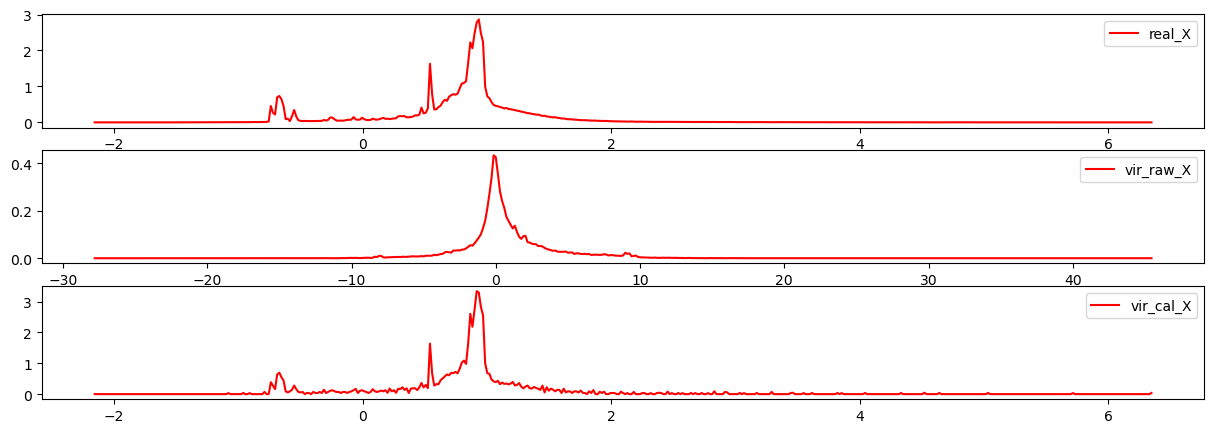

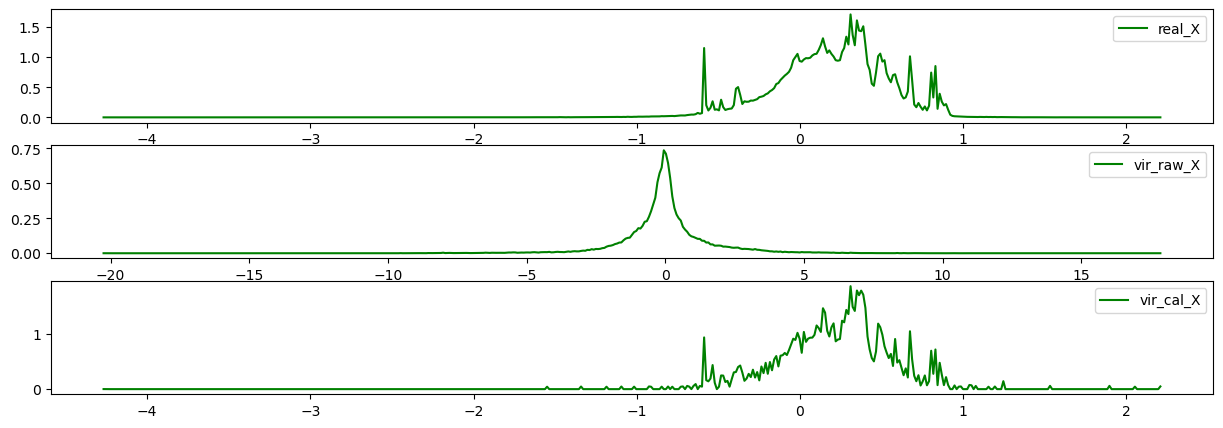

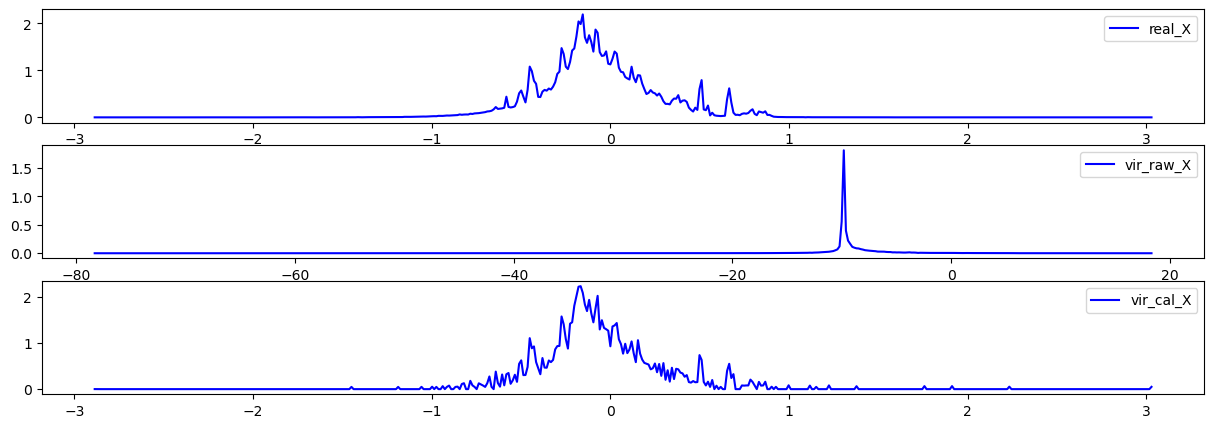

In [7]:
colors = ['r', 'g', 'b']
n_sample = 500
for ch in range(3):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,5))


    ''' real '''
    min_x, max_x = np.amin(X_real[:,ch]), np.amax(X_real[:,ch])
    x_plot = np.linspace(min_x, max_x, n_sample)
    log_dens, bin_edges = np.histogram(X_real[:,ch], bins=x_plot, density=True)
    axes[0].plot(x_plot[:-1], log_dens, color=colors[ch], label='real_X')
    axes[0].legend()

    ''' vir raw '''
    min_x, max_x = np.amin(X_vir_raw[:,ch]), np.amax(X_vir_raw[:,ch])
    x_plot = np.linspace(min_x, max_x, n_sample)
    log_dens, bin_edges = np.histogram(X_vir_raw[:,ch], bins=x_plot, density=True)
    axes[1].plot(x_plot[:-1], log_dens, color=colors[ch], label='vir_raw_X')
    axes[1].legend()

    '''vir cal '''
    min_x, max_x = np.amin(X_vir_cal[:,ch]), np.amax(X_vir_cal[:,ch])
    x_plot = np.linspace(min_x, max_x, n_sample)
    log_dens, bin_edges = np.histogram(X_vir_cal[:,ch], bins=x_plot, density=True)
    axes[2].plot(x_plot[:-1], log_dens, color=colors[ch], label='vir_cal_X')
    axes[2].legend()